Aim 1: design a pseudo bulk estimation procedure using random projection and tree data structure.

In [1]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import fastsca
import logging

In [2]:
experiment = '/projects/experiments/fastsca/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sca = fastsca.FASTSCA()
sca.config = args
sca.initdata()
sca.loaddata()
sca.data.mtx.shape

(155913, 20265)

In [3]:
import _rpstruct as rp
import importlib
importlib.reload(rp)


<module '_rpstruct' from '/home/BCCRC.CA/ssubedi/projects/experiments/fastsca/fastsca/_rpstruct.py'>

In [6]:
#pbmc
# min_leaf = 5
# max_depth = 25

#tnbc
min_leaf = 100
max_depth = 25


rp_mat = []
for i in range(max_depth):
    rp_mat.append(np.random.normal(size = (sca.data.mtx.shape[1],1)).flatten())

rp_mat = np.asarray(rp_mat)
rp_mat.shape


(25, 20265)

In [7]:

tree = rp.StepTree(sca.data.mtx,rp_mat)
tree.build_tree(min_leaf,max_depth)
bulkd = tree.make_bulk()
print(len(bulkd))
sum = 0
for k in bulkd.keys(): sum += len(bulkd[k])
print(sum)

3257
155913


In [8]:
tree.print_tree()

1 39205
1 116708
2 9440
2 29765
2 17774
2 98934
3 8484
3 956
3 27429
3 2336
3 14910
3 2864
3 95619
3 3315
4 3779
4 4705
4 485
4 471
4 18028
4 9401
4 1239
4 1097
4 5622
4 9288
4 608
4 2256
4 49505
4 46114
4 1544
4 1771
5 3641
5 138
5 4521
5 184
5 430
5 55
5 383
5 88
5 15539
5 2489
5 8273
5 1128
5 1149
5 90
5 989
5 108
5 5341
5 281
5 8862
5 426
5 541
5 67
5 808
5 1448
5 46177
5 3328
5 42291
5 3823
5 1095
5 449
5 1484
5 287
6 3155
6 486
6 99
6 39
6 4117
6 404
6 152
6 32
6 326
6 104
6 345
6 38
6 13684
6 1855
6 1723
6 766
6 6503
6 1770
6 883
6 245
6 954
6 195
6 673
6 316
6 91
6 17
6 4782
6 559
6 225
6 56
6 8568
6 294
6 367
6 59
6 303
6 238
6 607
6 201
6 98
6 1350
6 43724
6 2453
6 2949
6 379
6 39747
6 2544
6 3620
6 203
6 757
6 338
6 79
6 370
6 1252
6 232
6 247
6 40
7 2657
7 498
7 346
7 140
7 2992
7 1125
7 312
7 92
7 118
7 34
7 170
7 156
7 85
7 19
7 275
7 70
7 9952
7 3732
7 1606
7 249
7 1526
7 197
7 734
7 32
7 4893
7 1610
7 1251
7 519
7 784
7 99
7 215
7 30
7 679
7 275
7 143
7 52
7 425
7 248
7

In [9]:
fpath = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id

bulk = {}
for key, value in bulkd.items(): 
    bulk[key] = np.asarray(sca.data.mtx[value].sum(0))[0]

pd.DataFrame.from_dict(bulk,orient='index').to_csv(fpath+"_rp_bulk.csv.gz",compression='gzip',index=False)

In [15]:
fpath = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id

bulk_index = {}
for key, value in bulkd.items(): 
    bulk_index[key] = value

pd.DataFrame.from_dict(bulk_index,orient='index').to_csv(fpath+"_rp_bulk_index.csv.gz",compression='gzip',index=False)

Supplementary - 
Compare bulk assignment with label output from  scanpy tutorial

1 515
3 341
5 192
6 163
0 638
4 295
2 445
7 36
8 13


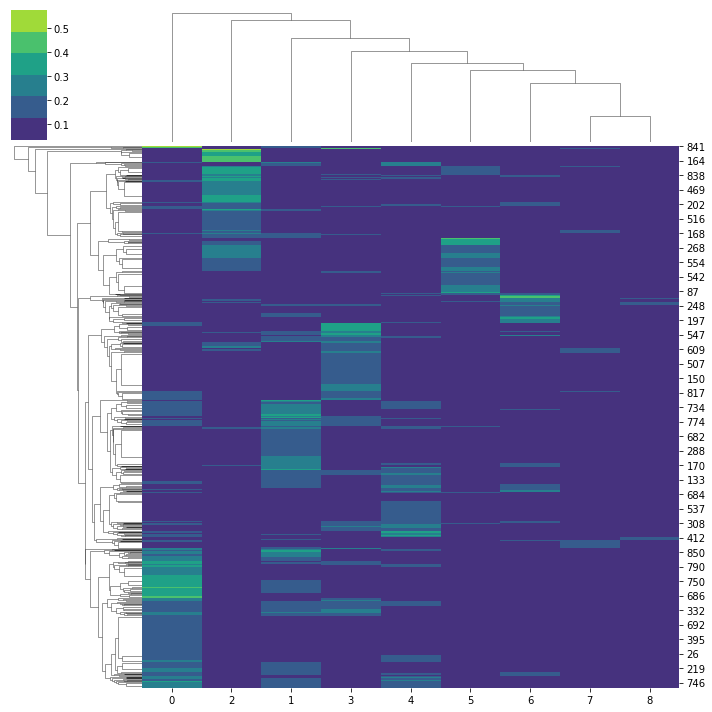

In [14]:
import matplotlib.pylab as plt
import seaborn as sns

# get label for bulkd
collapsed_dict = {}
for k in bulkd.keys():
    collapsed_dict[k] = np.array(sca.data.rows)[bulkd[k]]


# get prior scanpy label
dfp = pd.read_csv(fpath+'_prior_label.csv.gz')
dp = {}
for idx,row in dfp.iterrows():
    if row[1] in dp:
        dp[row[1]].append(row[0])
    else:
        dp[row[1]] = [row[0]]    
for k in dp.keys():print(k,len(dp[k]))

# count match
rp_count = []
for chk_indx in collapsed_dict.keys(): 
    cells = collapsed_dict[chk_indx]
    
    prior_count = []
    for k in dp.keys():
        count = 0
        for c in cells:
            if c in dp[k]: count += 1
        prior_count.append(count)
    rp_count.append(prior_count)
    
df_res = pd.DataFrame(rp_count)
df_res.columns = dp.keys()
df_res.index = collapsed_dict.keys()
df_res += 1  
df_res = df_res.div(df_res.sum(axis=1), axis=0)
sns.clustermap(df_res,cmap=sns.color_palette('viridis'))